## Q1: What is the distribution of the machines according to their CPU capacity?

In [44]:
import sys
from pyspark import SparkContext
import time
from pyspark.sql.functions import countDistinct
import timeit
import gc
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql import Row
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [45]:
import os

In [46]:
sns.set(color_codes=True)

In [47]:
def f(x):
    d = {}
    for i in range(len(x)):
        d[str(i)] = x[i]
    return d
def adjust_params(x):
    return x/10**6

read the data table "machine events":
    1. timestamp
    2. machine ID
    3. event type
    4. platform ID
    5. capacity: CPU
    6. capacity: memory
Description of the table:
    'event_type'    
    1. Contains information about the machines that went offline and reconnected during the period that the data covers

In [49]:
#if sc:
#    sc.stop()
    
sc = SparkContext("local[1]")
sc.setLogLevel("ERROR")

#0. timestamp 1. machineID 2. eventtype 3. platformID 4. capacity:CPU 5. capacity:memory
machine_events = sc.textFile('../../datasets/machine_events/*.gz')
machine_events_RDD = machine_events.map(lambda line: line.split(","))
machine_events_RDD = machine_events_RDD.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), tokens[3], tokens[4], tokens[5]))
machine_events_RDD_filtered = machine_events_RDD.map(lambda elem: (elem[0], elem[1], elem[2], elem[3], elem[4], elem[5])).filter(lambda elem: elem[0] != 0 and elem[0] != (2^63-1)).sortByKey(1, 1)

In [7]:
#sortByKey(accending=True, number of partitions)
print("{} traces removed".format(machine_events_RDD.count() - machine_events_RDD_filtered.count()))
print("Step 4: {}".format(machine_events_RDD_filtered.take(1)))

12477 traces removed
Step 4: [(779231019, 5782512, 1, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', '0.5', '0.2493')]


In [8]:
sqlContext = SQLContext(sc)
machine_events_df = sqlContext.createDataFrame(machine_events_RDD_filtered, schema=['timestamp', 'machineID', 'eventtype', 'platformID', 'CPU', 'memory'])

In [8]:
machine_events_df.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- machineID: long (nullable = true)
 |-- eventtype: long (nullable = true)
 |-- platformID: string (nullable = true)
 |-- CPU: string (nullable = true)
 |-- memory: string (nullable = true)



In [9]:
machine_events_df = machine_events_df.filter(machine_events_df.CPU!='')

In [19]:
## Get Statistics
statistics_timestamp = machine_events_df.describe('timestamp')
print(statistics_timestamp.show())
statistics_CPU = machine_events_df.describe('CPU')
print(statistics_CPU.show())
statistics_timestamp = machine_events_df.describe('memory')
print(statistics_timestamp.show())

+-------+--------------------+
|summary|           timestamp|
+-------+--------------------+
|  count|               16314|
|   mean|1.294475316201773...|
| stddev|7.178122891732922E11|
|    min|           974363601|
|    max|       2506129491172|
+-------+--------------------+

None
+-------+-------------------+
|summary|                CPU|
+-------+-------------------+
|  count|              16314|
|   mean| 0.5204578889297535|
| stddev|0.11419635148370541|
|    min|               0.25|
|    max|                  1|
+-------+-------------------+

None
+-------+-------------------+
|summary|             memory|
+-------+-------------------+
|  count|              16314|
|   mean| 0.4737559078092239|
| stddev|0.18057669652063252|
|    min|            0.06158|
|    max|                  1|
+-------+-------------------+

None


In [20]:
cpu_all = np.array(list(machine_events_df.toPandas()['CPU'])).astype(np.float32)

In [21]:
number_of_CPU = machine_events_df.groupBy('CPU').count()
print(number_of_CPU.show())

+----+-----+
| CPU|count|
+----+-----+
|0.25|  281|
| 0.5|15225|
|   1|  808|
+----+-----+

None


Text(0,0.5,'Machines')

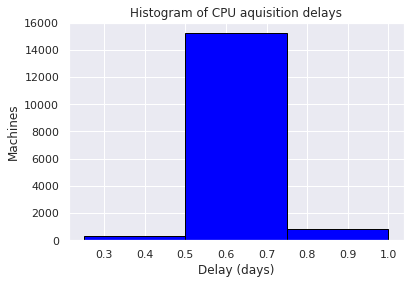

In [23]:
plt.hist(cpu_all, color='blue', edgecolor = 'black', bins=int(3))
plt.title('Histogram of CPU aquisition delays')
plt.xlabel('Delay (days)')
plt.ylabel('Machines')

In [259]:
from pyspark.sql import functions as F
day = 86400 
expr_end = [F.last(col).alias(col) for col in df.columns]
expr_start = [F.first(col).alias(col) for col in df.columns]
total_times = df.groupBy().agg(*expr_end).collect()[0][0] - df.groupBy().agg(*expr_start).collect()[0][0]
days = (total_times/10**6)/day
print(days)

28.997178964097223


In [1]:
#df.toPandas()['timestamp']

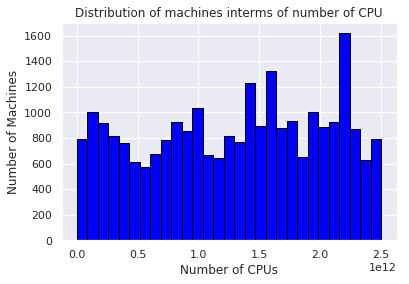

In [290]:
plt.hist(df.toPandas()['timestamp'], color='blue', edgecolor = 'black', bins=int(29))
plt.title('Distribution of machines interms of number of CPU')
plt.xlabel('Number of CPUs')
plt.ylabel('Number of Machines')
plt.show()

In [270]:
cluster1 = df.filter(df.CPU=='1').toPandas()
cluster2 = df.filter(df.CPU=='0.5').toPandas()
cluster3 = df.filter(df.CPU=='0.25').toPandas()

Histogram of CPU aquisition delays


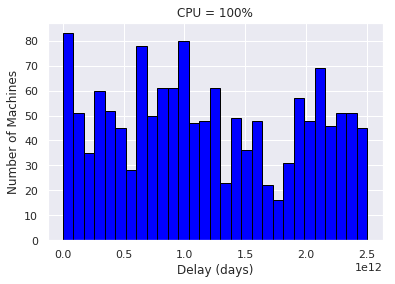

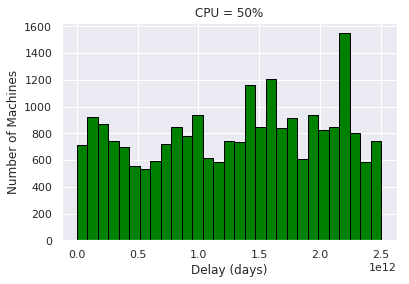

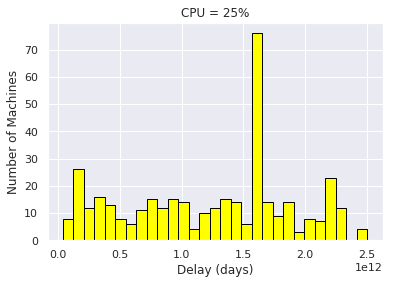

In [288]:
print("Histogram of CPU aquisition delays")
plt.hist(cluster1['timestamp'], color='blue', edgecolor = 'black', bins=int(29), label='CPU 1')
plt.title('CPU = 100%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()
plt.hist(cluster2['timestamp'], color='green', edgecolor = 'black', bins=int(29), label='CPU 0.5')
plt.title('CPU = 50%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()
plt.hist(cluster3['timestamp'], color='yellow', edgecolor = 'black', bins=int(29), label='CPU 0.25')
plt.title('CPU = 25%')
plt.xlabel('Delay (days)')
plt.ylabel('Number of Machines')
plt.show()

In [295]:
#from pyspark.mllib.stat import Statistics
#import pandas as pd

#df_rdd = df.rdd.map(lambda row: row)
#corr_matrix = Statistics.corr(df_rdd, method='pearson')
#corr_mat_df = pd.DataFrame(corr_mat,
#                    columns=df.columns, 
#                    index=df.columns)

Py4JJavaError: An error occurred while calling o3501.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 200.0 failed 1 times, most recent failure: Lost task 0.0 in stage 200.0 (TID 4105, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.sql.types.Row'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1337)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1378)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1377)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.numCols(RowMatrix.scala:61)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:331)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:74)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.corr(PythonMLLibAPI.scala:843)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/gazizullina150/anaconda3/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.sql.types.Row'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## Q2: On average, how many tasks compose a job?

Task Events Table
1. timestamp
2. missing info
3. job ID
4. task index - within the job
5. machine ID
6. event type
7. user name
8. scheduling class
9. priority
10. resource request for CPU cores
11. resource request for RAM
12. resource request for local disk space
13. different-machine constraint

In [19]:
task_events = sc.textFile('../../datasets/task_events/part-00000-of-00500.csv.gz')
task_events_RDD = task_events.map(lambda line: line.split(","))
print("Step 1: {}".format(task_events_RDD.take(5)))
task_events_RDD = task_events_RDD.map(lambda tokens: (tokens[0], tokens[2], tokens[3], tokens[4], tokens[5], tokens[6], tokens[7], tokens[8], tokens[9], tokens[10], tokens[11], tokens[12]))
print("Step 1: {}".format(task_events_RDD.take(5)))
task_events_RDD = task_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '' and elem[3] !='')
print("Step 1: {}".format(task_events_RDD.take(5)))
sqlContext = SQLContext(sc)
task_events_df = sqlContext.createDataFrame(task_events_RDD, schema=['timestamp', 'jobID', 'taskID', 'machineID', 'eventType', 'userName', 'schedulingClass', 'priority', 'CPUreq', 'RAMreq', 'diskreq', 'const'])

Step 1: [['0', '2', '3418309', '0', '4155527081', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '', '', '', ''], ['0', '2', '3418309', '1', '329150663', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '', '', '', ''], ['0', '', '3418314', '0', '3938719206', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '0.125', '0.07446', '0.0004244', '0'], ['0', '', '3418314', '1', '351618647', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '0.125', '0.07446', '0.0004244', '0'], ['0', '2', '3418319', '0', '431052910', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '', '', '', '']]
Step 1: [('0', '3418309', '0', '4155527081', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '', '', '', ''), ('0', '3418309', '1', '329150663', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '', '', '', ''), ('0', '3418314', '0', '3938719206', '0', '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', '3', '9', '0.125',

In [11]:
##remove the machine with the id that corresponds to the one in the table machine event with event_type=1
#task_events_df = task_events_df.join(machine_events_df, "machineID", "leftanti")

In [10]:
from pyspark.sql.functions import *
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))
dupes = task_events_df.groupBy('jobID').agg(collect_list('taskID').alias("taskIDs"))
dupes_rdd = dupes.rdd.map(lambda x: list(x)).map(lambda x: (x[0], len(list(set(x[1])))))

In [11]:
dupes_rdd.take(3)

[('3350267310', 1), ('3760070065', 2), ('3800750574', 1)]

number of tasks per job on the average

In [14]:
dupes_rdd.values().sum()/dupes.count()

36.82660381225661

## Q3: What is the percentage of jobs/tasks that got killed or evicted?

1. timestamp
2. missing info
3. job ID
4. event type
5. user name
6. scheduling class
7. job name
8. logical job name
If a task or job that has just EVICTed, FAILed, or KILLed remains runnable, a SUBMIT event
will appear immediately after the descheduling events. (I.e., the system tries to restart jobs
and tasks that have failed.)

This means that a job or task was submitted and immediately scheduled,
or, if the timestamp on the events is 0, that the job or task was submitted and scheduled
before the trace began.


● SUBMIT (0): A task or job became eligible for scheduling.
● SCHEDULE (1): A job or task was scheduled on a machine. (It may not start running
immediately due to code-shipping time, etc.) For jobs, this occurs the first time any
task of the job is scheduled on a machine.
● EVICT(2): A task or job was descheduled because of a higher priority task or job,
because the scheduler overcommitted and the actual demand exceeded the machine
capacity, because the machine on which it was running became unusable (e.g. taken
offline for repairs), or because a disk holding the task’s data was lost.
● FAIL(3): A task or job was descheduled (or, in rare cases, ceased to be eligible for
scheduling while it was pending) due to a task failure.
● FINISH(4): A task or job completed normally.
● KILL(5): A task or job was cancelled by the user or a driver program or because
another job or task on which this job was dependent died.
● LOST(6): A task or job was presumably terminated, but a record indicating its
termination was missing from our source data.
● UPDATE_PENDING(7): A task or job’s scheduling class, resource requirements, or
constraints were updated while it was waiting to be scheduled.
● UPDATE_RUNNING(8): A task or job’s scheduling class, resource requirements, or
constraints were updated while it was scheduled.

In [7]:
jobs_dir = '../../datasets/job_events/'
list_of_jobs = [os.path.join(jobs_dir, o) for o in os.listdir(jobs_dir) if os.path.splitext(o)[-1].lower()=='.gz']

In [8]:
tasks_dir = '../../datasets/task_events/'
list_of_tasks = [os.path.join(tasks_dir, o) for o in os.listdir(tasks_dir) if os.path.splitext(o)[-1].lower()=='.gz']

In [9]:
job_events = sc.textFile(','.join(list_of_jobs))
#rdds = []
#for f in list_of_jobs:
#    rdd = sc.textFile(f)
#    rdds.append(rdd)
#bigRdd = sc.union(rdds)
job_events_RDD = job_events.map(lambda line: line.split(","))
job_events_RDD = job_events_RDD.map(lambda tokens: (tokens[0], tokens[2], int(tokens[3]), tokens[4], tokens[5], tokens[6], tokens[7]))
print("Step 1: {}".format(job_events_RDD.take(5)))
job_events_RDD = job_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '')
sqlContext = SQLContext(sc)
job_events_df = sqlContext.createDataFrame(job_events_RDD, schema=['timestamp', 'jobID', 'eventType', 'userName', 'schedulingClass', 'jobName', 'logicalJobName'])

Step 1: [('1639265380304', '6408251525', 4, 'jVEIdGnEYLp+j9YJHh5dEBhUdpD2fs+PKTWwQo5ZrJk=', '1', 'zXOstV9tbQGnXU6u6FfAjOzoe8gToH3sDCKZNm0RAwM=', '1H3WBVcen2RS9lximFVb5A/HIAxc6rH8XBp0IStE/Co='), ('1639266126599', '6408242568', 4, 'E+9U+J1Dicd5PJklbq2e5THQ29X6D8jmqQ0Zu53Kc+o=', '1', 'zIJN2SX7SNXpmhsI4p174hllWbDrYsiN3jmi89qIoLE=', 'pGMncQqmkkb0gbI/JrHgzi7Mtg9f3V5OMLAEau6JnpM='), ('1639275560475', '6405047060', 4, 'YPTpZCeEjWP/khLtXrzAz0QDQJH7tRyUmxLsZzBNrdY=', '1', 'I4KvX1i2+NYaFkFHz6i+BDpZAWEje/tVhsRNCwiM5Gc=', '1EJtggv0Pv+M6YpPkavCVKOQ2Y4llq2nU9N2rB470z0='), ('1639276324947', '6408247924', 4, 'r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=', '2', 'Y5xihLoAL+/FZdosrWck737QafsLFrX2HFm0d5ExD5Q=', 'G/9E4AW9fSviXbmdFO5BBcjVd49zuI1AIU5gHQJLm+8='), ('1639276325133', '6408248034', 5, 'r/Al6kYJOwZITr6wi4pAlEwyGv5TM2EkJ8woA5hszeA=', '0', 'PtTFrwRNMtU7qutjUNORTQR2bEfh6Pn8lVqPvdk9h74=', 'QdrSScSXyIpoqR4skT9QFLlVShlxNDTFRBhIWZRq2SM=')]


In [10]:
total_jobs = job_events_df.count()

In [25]:
evicted_jobs = job_events_df.where((job_events_df['eventType']==int(2)) | (job_events_df['eventType']==int(5)))
evicted_count = evicted_jobs.select('jobID').distinct().count()
evicted_rat = (evicted_count*100)/total_jobs

In [26]:
evicted_rat

13.535300426091892

In [28]:
big_tasks_events = sc.textFile(','.join(list_of_tasks))
#big_tasks_events = sc.textFile('../../datasets/task_events/part-00000-of-00500.csv.gz')

In [29]:
big_tasks_events_RDD = big_tasks_events.map(lambda line: line.split(","))
big_tasks_events_RDD = big_tasks_events_RDD.map(lambda tokens: (tokens[0], tokens[2], tokens[3], tokens[4], int(tokens[5]), tokens[6], tokens[7], tokens[8], tokens[9], tokens[10], tokens[11], tokens[12]))
big_tasks_events_RDD = big_tasks_events_RDD.filter(lambda elem: elem[1] != '' and elem[2] != '')
sqlContext = SQLContext(sc)
big_tasks_events_df = sqlContext.createDataFrame(big_tasks_events_RDD, schema=['timestamp', 'jobID', 'taskID', 'machineID', 'eventType', 'userName', 'schedulingClass', 'priority', 'CPUreq', 'RAMrec', 'diskRec', 'const'])

In [31]:
total_tasks = big_tasks_events_df.count()
evicted_tasks = big_tasks_events_df.where((big_tasks_events_df['eventType']==int(2)) | (big_tasks_events_df['eventType']==int(5)))
evicted_tasks_count = evicted_tasks.select('jobID', 'taskID').distinct().count()
evicted_tasks_rat = (evicted_count*100)/total_tasks

In [32]:
evicted_tasks_rat

0.18829327589414677

#### Answer: 
        evicted and killed jobs percentage - 13.53 %
        evicted and killed tasks percentage - 0.18 %

## Q4: Do tasks with low priority have a higher probability of being evicted?

In [ ]:
1. pr of each priority to be eviced

In [92]:
task_events_count = task_events_df.count()

In [93]:
s1 = sc.broadcast(task_events_count)

In [112]:
task_events_count

330581

In [122]:
evicted_priority = task_events_df.where(task_events_df['eventType']==int(2)).select('eventType', 'priority')
task_events_count = task_events_df.count()
print(task_events_count)
evicted_priority_rdd = evicted_priority.rdd.map(lambda x: (int(x[1]), 1))
print(evicted_priority_rdd.count())

330581
4338


In [124]:
evicted_priority_rdd = evicted_priority_rdd.reduceByKey(lambda x, y: x+y)
#.map(lambda x: (int(x[0]), float((x[1]*100)/s1)))
print("Step 4: {}".format(evicted_priority_rdd.take(30)))

Step 4: [(2, 55), (0, 4208), (1, 52), (9, 22), (10, 1)]


In [125]:
evicted_priority_np = evicted_priority_rdd.map(lambda x: (x[0], (x[1]*100/task_events_count)))
evicted_priority_np.take(10)

[(2, 0.0166373748037546),
 (0, 1.2729104213490794),
 (1, 0.015729881632640715),
 (9, 0.00665494992150184),
 (10, 0.00030249772370462914)]

## Q5: Is there a relation between the priority of a task and the amount of resources available on the machine it runs on?

In [155]:
machine_events_df.where(machine_events_df['machineID']=='5782512').select('machineID', 'CPU', 'memory').distinct().rdd.map(lambda row : row[0]).collect()[0]

5782512

In [15]:
#machine_events_dict = machine_events_df.select('machineID', 'CPU', 'memory').distinct()

In [65]:
machine_events_dict = machine_events_df.dropDuplicates(['machineID']).select('machineID', 'CPU', 'memory')

In [66]:
machine_events_dict = machine_events_dict.toPandas().set_index('machineID').T.to_dict('list')

In [67]:
machine_events_dict

{26: ['0.5', '0.2493'],
 1093605: ['0.5', '0.2493'],
 1271879: ['0.5', '0.4995'],
 1272595: ['0.5', '0.4995'],
 6565013: ['0.5', '0.4995'],
 38759120: ['0.5', '0.2493'],
 63616951: ['0.5', '0.2493'],
 63691343: ['0.5', '0.2493'],
 69135749: ['0.5', '0.4995'],
 228617778: ['0.5', '0.2493'],
 294901605: ['0.5', '0.2493'],
 305387618: ['0.5', '0.2493'],
 317510257: ['0.5', '0.749'],
 351627471: ['0.5', '0.4995'],
 431086627: ['0.5', '0.4995'],
 438722692: ['0.5', '0.2493'],
 501449548: ['0.5', '0.2493'],
 1436345330: ['0.5', '0.4995'],
 1436368948: ['0.5', '0.4995'],
 2198122741: ['0.5', '0.4995'],
 2598129300: ['0.5', '0.4995'],
 3337943252: ['0.25', '0.2498'],
 4133620037: ['0.5', '0.4995'],
 4153336080: ['0.5', '0.2493'],
 4156962711: ['0.25', '0.2498'],
 4477653797: ['0.5', '0.4995'],
 4820075718: ['1', '1'],
 5297461910: ['0.5', '0.2493'],
 5361768622: ['1', '1'],
 904566: ['0.5', '0.4995'],
 1270749: ['0.5', '0.4995'],
 1332073: ['0.5', '0.4995'],
 1734648: ['0.5', '0.4995'],
 65676

In [68]:
#list_machine_events = map(lambda row: row.asDict(), machine_events_dict.collect())
#dict_machine_events = {str(person['machineID']): person for person in machine_events_dict}

In [74]:
dict_machine_events_bc = sc.broadcast(machine_events_dict)

In [116]:
def get_resources(x, p):
    #print(type(x))
    if dict_machine_events_bc.value.get(int(x)) is not None:
        dict_val = dict_machine_events_bc.value.get(int(x))
    else:
        dict_val = (x, str(x), '00.0')
    #machine_events_df.where(machine_events_dict['machineID']==x).rdd.map(lambda row : row[0]).collect()[0]
    #print(val1)
    #cpu, memory
    return (x, dict_val[0], dict_val[1], p)

In [117]:
task_events_df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- jobID: string (nullable = true)
 |-- taskID: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- userName: string (nullable = true)
 |-- schedulingClass: string (nullable = true)
 |-- priority: string (nullable = true)
 |-- CPUreq: string (nullable = true)
 |-- RAMrec: string (nullable = true)
 |-- diskRec: string (nullable = true)
 |-- const: string (nullable = true)



In [118]:
task_events_rdd = task_events_df.rdd.map(tuple)
#.map(lambda x: get_resources(x[0])).collect()

In [119]:
resources_rdd = task_events_rdd.map(lambda x: get_resources(x[3], x[7]))
#machineID, CPU, memory, priority
#machine_events_df.where(machine_events_dict['machineID']==x['machineID']).rdd.map(lambda row : row[0]).collect()[0]).collect()

In [126]:
total = resources_rdd.count()

In [133]:
resources_rdd.take(4)

[('4155527081', '0.5', '0.2493', '9'),
 ('329150663', '329150663', '329150663', '9'),
 ('3938719206', '3938719206', '3938719206', '9'),
 ('351618647', '0.5', '0.4995', '9')]

In [155]:
present_rdd = resources_rdd.filter(lambda x: x[1]!='00.0').map(lambda x: (x[0], float(x[1]), float(x[2]), int(x[3])))
present = present_rdd.count()

In [156]:
print("There are {}% machineIDs missing".format(100*int(total - present)/total))

There are 0.0% machineIDs missing


In [163]:
sqlContext = SQLContext(sc)
present_df = sqlContext.createDataFrame(present_rdd, schema=['machineID', 'CPU', 'memory', 'priority'])

In [164]:
present_df_distinct = present_df.select('machineID', 'CPU', 'memory', 'priority').distinct().select('CPU', 'memory', 'priority')

In [169]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
r = ChiSquareTest.test(present_df_distinct, 'prioriy', 'CPU', 'memory').head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

TypeError: test() takes 3 positional arguments but 4 were given

In [166]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=present_df_distinct.columns, outputCol=vector_col)
df_vector = assembler.transform(present_df_distinct).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [168]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.       ,  1.       , -0.0314909,  1.       ,  1.       ,
       -0.0314909, -0.0314909, -0.0314909,  1.       ])

         priority     CPU         memory 
priority               1.         -0.0314909
CPU      1.                       -0.0314909
memory   -0.0314909  -0.0314909




In [170]:
#present_df_distinct.show()
#present_df_distinct.show()

## Q6: Are there tasks that consume significantly less resources than what they requested?

1. starttime ofthemeasurementperiod
2. endtime ofthemeasurementperiod
3. jobID
4. taskindex
5. machineID
6. meanCPUusagerate
7. canonicalmemoryusage
8. assignedmemoryusage
9. unmappedpagecachememoryusage 10. total page cache memory usage
11. maximum memory usage
12. mean disk I/O time
13. mean local disk space used
14. maximum CPU usage
15. maximum disk IO time
16. cycles per instruction (CPI)
17. memory accesses per instruction (MAI)
18. sample portion
19. aggregation type (1 if maximums from subcontainers were summed) 

20. sampled CPU usage: mean CPU usage during a random 1s sample in the measurement period  (only in v2.1 and later)




In [16]:
import pyspark.sql.functions as f

In [12]:
task_usage = sc.textFile('../../datasets/task_usage/part-00000-of-00500.csv')

In [14]:
task_usage = sc.textFile('../../datasets/task_usage/part-00000-of-00500.csv')
task_usage_colnames=['starttime', 'endtime', 'jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage', 
                         'assigned_mem', 'unmapped_cache_usage', 'page_cache_usage', 'max_mem_usage', 'disk_io_time', 
                         'max_disk_space', 'max_cpu_usage', 'max_disk_io_time', 'cpi', 'mai', 'sampling_rate', 'agg_type', 'sampled_cpu_usage']

task_usage = task_usage.map(lambda line: line.split(","))
task_usage = task_usage.filter(lambda X: '' not in X)
task_usage = task_usage.map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4]), float(tokens[5]), float(tokens[6]), float(tokens[7]), float(tokens[8]), float(tokens[9]), float(tokens[10]), float(tokens[11]), float(tokens[12]), float(tokens[13]), float(tokens[14]), float(tokens[15]), float(tokens[16]), int(tokens[17]), int(tokens[18]), float(tokens[19])))
sqlContext = SQLContext(sc)
task_usage_df = sqlContext.createDataFrame(task_usage, schema=task_usage_colnames)
task_usage_df_1 = task_usage_df.select('jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage').distinct()

+---------+-------+------+----------+---------+--------------------+---------------+--------+------+-------+---------+-----+
|timestamp|  jobID|taskID| machineID|eventType|            userName|schedulingClass|priority|CPUreq| RAMreq|  diskreq|const|
+---------+-------+------+----------+---------+--------------------+---------------+--------+------+-------+---------+-----+
|        0|3418309|     0|4155527081|        0|70s3v5qRyCO/1PCdI...|              3|       9|      |       |         |     |
|        0|3418309|     1| 329150663|        0|70s3v5qRyCO/1PCdI...|              3|       9|      |       |         |     |
|        0|3418314|     0|3938719206|        0|70s3v5qRyCO/1PCdI...|              3|       9| 0.125|0.07446|0.0004244|    0|
|        0|3418314|     1| 351618647|        0|70s3v5qRyCO/1PCdI...|              3|       9| 0.125|0.07446|0.0004244|    0|
|        0|3418319|     0| 431052910|        0|70s3v5qRyCO/1PCdI...|              3|       9|      |       |         |     |


In [33]:
task_usage_df_1 = task_usage_df.select('jobID', 'taskID', 'machineID', 'cpu_usage', 'mem_usage').distinct()
task_events_df_distinct = task_events_df.dropDuplicates(['machineID', 'jobID', 'taskID']).where(col("CPUreq").isNotNull()).where(col("RAMreq").isNotNull())
#if cpu/mem_rat < 1 => we consume less than request

In [50]:
df = task_events_df_distinct.join(task_usage_df_1, (task_events_df_distinct.jobID == task_usage_df_1.jobID) & (task_events_df_distinct.machineID == task_usage_df_1.machineID) & (task_events_df_distinct.taskID == task_usage_df_1.taskID))
df.show()

+---------+---------+------+---------+---------+--------------------+---------------+--------+-------+-------+---------+-----+---------+------+---------+---------+---------+
|timestamp|    jobID|taskID|machineID|eventType|            userName|schedulingClass|priority| CPUreq| RAMreq|  diskreq|const|    jobID|taskID|machineID|cpu_usage|mem_usage|
+---------+---------+------+---------+---------+--------------------+---------------+--------+-------+-------+---------+-----+---------+------+---------+---------+---------+
|        0| 39308688|     1|  1099042|        0|70s3v5qRyCO/1PCdI...|              3|       9|       |       |         |     | 39308688|     1|  1099042|  1.65E-4|  0.03296|
|        0| 39308688|     1|  1099042|        0|70s3v5qRyCO/1PCdI...|              3|       9|       |       |         |     | 39308688|     1|  1099042| 1.411E-4|  0.03296|
|        0| 39308688|     1|  1099042|        0|70s3v5qRyCO/1PCdI...|              3|       9|       |       |         |     | 393

In [63]:
demand = task_events_df_distinct.join(task_usage_df_1, on=['jobID', 'taskID', 'machineID'])
demand.show()

+---------+------+---------+---------+---------+--------------------+---------------+--------+------+-------+---------+-----+---------+---------+
|    jobID|taskID|machineID|timestamp|eventType|            userName|schedulingClass|priority|CPUreq| RAMreq|  diskreq|const|cpu_usage|mem_usage|
+---------+------+---------+---------+---------+--------------------+---------------+--------+------+-------+---------+-----+---------+---------+
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0|  0.03186| 0.008484|
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0|  0.03204| 0.008423|
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0|  0.03076|  0.00827|
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0

In [69]:
demand = demand.withColumn("cpu_rat", (col('cpu_usage')/col('CPUreq'))).withColumn("ram_rat", (col('mem_usage')/col('RAMreq'))).withColumn("res_rat", ((col('mem_usage')+col('cpu_usage'))/(col('RAMreq')+col('CPUreq'))))
#.orderBy('res_rat', ascending=True)
demand.show()

+---------+------+---------+---------+---------+--------------------+---------------+--------+------+-------+---------+-----+---------+---------+-------+-------------------+-------------------+
|    jobID|taskID|machineID|timestamp|eventType|            userName|schedulingClass|priority|CPUreq| RAMreq|  diskreq|const|cpu_usage|mem_usage|cpu_rat|            ram_rat|            res_rat|
+---------+------+---------+---------+---------+--------------------+---------------+--------+------+-------+---------+-----+---------+---------+-------+-------------------+-------------------+
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0|  0.03186| 0.008484|0.50976|0.08676620985886684| 0.2517095083603693|
| 17109330|   109|336074059|        0|        0|WVtO5qw3sNnP4MeiR...|              3|       9|0.0625|0.09778|0.0005016|    0|  0.03204| 0.008423|0.51264|0.08614236040089997|0.25245195907162465|
| 17109330|   109|336074059|  

In [71]:
demand = demand.select('jobID', 'taskID', 'machineID', 'CPUreq', 'cpu_usage', 'cpu_rat', 'RAMreq', 'mem_usage', 'ram_rat', 'res_rat')

In [72]:
demand.where(col('res_rat')<1).count()

1661028

In [73]:
demand.where(col('res_rat')==1).count()

25

In [74]:
demand.where(col('res_rat')>1).count()

298993

## Q7: Are there machines for which the resources are largely underused?

In [76]:
machine_events_df_unique = machine_events_df.dropDuplicates(['machineID'])
demand = task_usage_df_1.join(machine_events_df, on=['machineID'])
demand.show()

+---------+----------+------+---------+---------+-------------+---------+--------------------+---+------+
|machineID|     jobID|taskID|cpu_usage|mem_usage|    timestamp|eventtype|          platformID|CPU|memory|
+---------+----------+------+---------+---------+-------------+---------+--------------------+---+------+
|       26|5984979082|    13| 0.002266| 0.001081| 611893094118|        1|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|5984979082|    13| 0.002266| 0.001081| 700559974858|        0|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|5984979082|    13| 0.002266| 0.001081| 700559975977|        2|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|5984979082|    13| 0.002266| 0.001081|1886486566970|        2|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|5984979082|    13| 0.002266| 0.001081|1896956086270|        2|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|6114773114|  1932| 1.984E-4| 0.001486| 611893094118|        1|HofLGzk1Or/8Ildj2...|0.5|0.2493|
|       26|6114773114|  1932| 1.984E-4| 0.0014

In [78]:
demand = demand.select('machineID', 'jobID', 'taskID', 'cpu_usage', 'mem_usage', 'CPU', 'memory').withColumn('cpu_used_rat', (100*col('cpu_usage')/col('CPU'))).withColumn('ram_used_rat', (100*col('mem_usage')/col('memory'))).withColumn('res_used_rat', (100*(col('mem_usage')+col('cpu_usage'))/(col('memory')+col('cpu'))))
demand.show()

+---------+----------+------+---------+---------+---+------+-------------------+-------------------+-------------------+
|machineID|     jobID|taskID|cpu_usage|mem_usage|CPU|memory|       cpu_used_rat|       ram_used_rat|       res_used_rat|
+---------+----------+------+---------+---------+---+------+-------------------+-------------------+-------------------+
|       26|5984979082|    13| 0.002266| 0.001081|0.5|0.2493|0.45319999999999994|0.43361411953469714| 0.4466835713332444|
|       26|5984979082|    13| 0.002266| 0.001081|0.5|0.2493|0.45319999999999994|0.43361411953469714| 0.4466835713332444|
|       26|5984979082|    13| 0.002266| 0.001081|0.5|0.2493|0.45319999999999994|0.43361411953469714| 0.4466835713332444|
|       26|5984979082|    13| 0.002266| 0.001081|0.5|0.2493|0.45319999999999994|0.43361411953469714| 0.4466835713332444|
|       26|5984979082|    13| 0.002266| 0.001081|0.5|0.2493|0.45319999999999994|0.43361411953469714| 0.4466835713332444|
|       26|6114773114|  1932| 1.

In [79]:
demand.count()

4014113

In [80]:
hist = demand.select('cpu_used_rat', 'ram_used_rat', 'res_used_rat')

percentage of CPUs being used

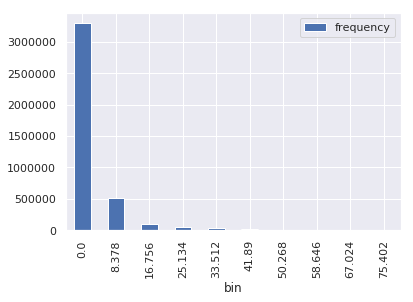

In [84]:
hist_cpu = hist.select('cpu_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_cpu)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

percentage of RAM being used

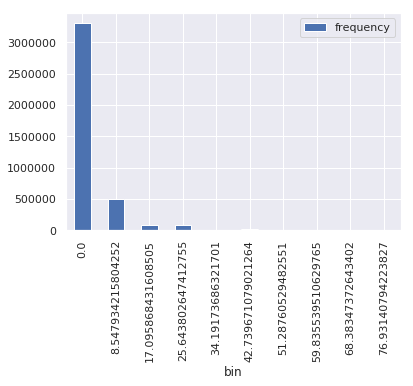

In [85]:
hist_ram = hist.select('ram_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_ram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

percentage of overall resources (ram+cpu) being used

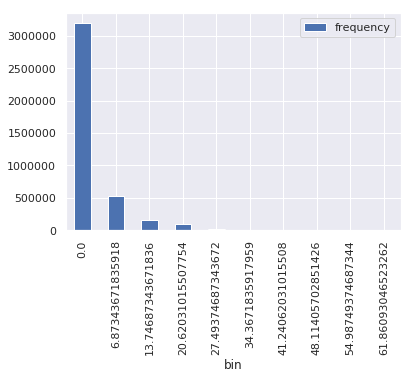

In [86]:
hist_res = hist.select('res_used_rat').rdd.flatMap(lambda x: x).histogram(10)
pd.DataFrame(
    list(zip(*hist_res)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

### UDFs

In [187]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf
time_udf = udf(lambda x: adjust_params(x), FloatType())

df2 = df2.select('timestamp', time_udf('timestamp'))

DataFrame[timestamp: float, <lambda>(timestamp): float]